In [1]:
from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/opt/conda/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
!pip install pyconll

Looking in indexes: http://dgi-dt-lgsapp01.dev.msci.org:11000/repository/python-otw/simple


In [4]:
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics.classification import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
import tensorflow as tf
#import tensorflow_hub as hub
import numpy as np
#import tensorflow_text
import warnings
from tqdm import tqdm_notebook
from IPython.display import Image 
#warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
#from bert.tokenization import FullTokenizer



In [5]:
path = 'noun-verb/dev.conll'
data = pyconll.load_from_file(path)

In [6]:
data[0][0].form

'Once'

In [7]:

def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos=='NN':
                tagged_sentence.append((token.form.lower(), str(token.upos)))
            elif token.upos=='VERB':
                tagged_sentence.append((token.form.lower(), str(token.upos)))
            else:
                tagged_sentence.append((token.form.lower(), 'None'))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences
                                   
dev = read_conllu('noun-verb/dev.conll')


In [9]:
dev[:2]

[[('once', 'None'),
  ('you', 'None'),
  ('have', 'None'),
  ('the', 'None'),
  ('new', 'None'),
  ('glass', 'None'),
  (',', 'None'),
  ('cleaning', 'VERB'),
  ('and', 'None'),
  ('replacing', 'None'),
  ('it', 'None'),
  ('is', 'None'),
  ('all', 'None'),
  ('that', 'None'),
  ("'s", 'None'),
  ('left', 'None'),
  ('.', 'None')],
 [('the', 'None'),
  ('catchment', 'None'),
  ('is', 'None'),
  ('situated', 'None'),
  ('on', 'None'),
  ('sandstone', 'None'),
  ('which', 'None'),
  ('has', 'None'),
  ('a', 'None'),
  ('low', 'None'),
  ('rate', 'None'),
  ('of', 'None'),
  ('weathering', 'VERB'),
  ('.', 'None')]]

In [10]:
train = read_conllu('noun-verb/train.conll')
test = read_conllu('noun-verb/test.conll')

In [11]:
train[:3]

[[('license', 'NN'),
  ('plates', 'None'),
  ('of', 'None'),
  ('cars', 'None'),
  ('from', 'None'),
  ('your', 'None'),
  ('area', 'None'),
  ('or', 'None'),
  ('your', 'None'),
  ('destination', 'None'),
  ('.', 'None')],
 [('two', 'None'),
  ('early', 'None'),
  ('seahawk', 'None'),
  ('miscues', 'None'),
  ('enabled', 'None'),
  ('the', 'None'),
  ('saints', 'None'),
  ('to', 'None'),
  ('build', 'None'),
  ('a', 'None'),
  ('10-point', 'None'),
  ('lead', 'None'),
  ('.', 'None')],
 [('we', 'None'),
  ('also', 'None'),
  ('find', 'None'),
  ('out', 'None'),
  ('the', 'None'),
  ('real', 'None'),
  ('reason', 'None'),
  ('for', 'None'),
  ('phil', 'None'),
  ('being', 'None'),
  ('late', 'None'),
  ('this', 'None'),
  ('morning', 'None'),
  (':', 'None'),
  ('he', 'None'),
  ('was', 'None'),
  ('presenting', 'None'),
  ('his', 'None'),
  ('portfolio', 'None'),
  ('at', 'None'),
  ('the', 'None'),
  ('glasgow', 'None'),
  ('school', 'None'),
  ('of', 'None'),
  ('art.', 'None'),
  (

In [12]:
test[:3]

[[('retail', 'None'),
  ('goods', 'None'),
  ('were', 'None'),
  ('seldom', 'None'),
  ('sold', 'None'),
  ('with', 'None'),
  ('shipping', 'None'),
  ('any', 'None'),
  ('faster', 'None'),
  ('than', 'None'),
  ('overnight', 'None'),
  ('.', 'None')],
 [('if', 'None'),
  ('you', 'None'),
  ("'ve", 'None'),
  ('changed', 'None'),
  ('this', 'None'),
  (',', 'None'),
  ('press', 'VERB'),
  ('``', 'None'),
  ('preview', 'None'),
  ("''", 'None'),
  ('to', 'None'),
  ('update', 'None'),
  ('this', 'None'),
  ('message', 'None'),
  ('.', 'None')],
 [('and', 'None'),
  ('the', 'None'),
  ('table', 'None'),
  ('must', 'None'),
  ('contain', 'None'),
  ('both', 'None'),
  ('the', 'None'),
  ('amount', 'None'),
  ('of', 'None'),
  ('that', 'None'),
  ('nutrient', 'None'),
  ('per', 'None'),
  ('serving', 'None'),
  ('and', 'None'),
  ('the', 'None'),
  ('%', 'None'),
  ('that', 'None'),
  ('nutrient', 'None'),
  ('represents', 'None'),
  ('as', 'None'),
  ('compared', 'None'),
  ('to', 'None')

In [13]:
# treebank_corpus = treebank.tagged_sents(tagset='universal')
# brown_corpus = brown.tagged_sents(tagset='universal')
# conll_corpus = conll2000.tagged_sents(tagset='universal')
# tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [13]:
tagged_sentences = train+dev

In [14]:
tagged_sentences[7]

[('some', 'None'),
 ('proponents', 'None'),
 ('of', 'None'),
 ('strong', 'None'),
 ('ai', 'None'),
 ('speculated', 'None'),
 ('that', 'None'),
 ('computers', 'None'),
 ('in', 'None'),
 ('connection', 'None'),
 ('with', 'None'),
 ('blue', 'None'),
 ('brain', 'None'),
 ('and', 'None'),
 ('soul', 'None'),
 ('catcher', 'None'),
 ('may', 'None'),
 ('exceed', 'None'),
 ('human', 'None'),
 ('intellectual', 'None'),
 ('capacity', 'None'),
 ('by', 'None'),
 ('around', 'None'),
 ('2015', 'None'),
 (',', 'None'),
 ('and', 'None'),
 ('that', 'None'),
 ('it', 'None'),
 ('is', 'None'),
 ('likely', 'None'),
 ('that', 'None'),
 ('we', 'None'),
 ('will', 'None'),
 ('be', 'None'),
 ('able', 'None'),
 ('to', 'None'),
 ('download', 'None'),
 ('the', 'None'),
 ('human', 'None'),
 ('brain', 'None'),
 ('at', 'None'),
 ('some', 'None'),
 ('time', 'None'),
 ('around', 'None'),
 ('2050', 'None'),
 ('.', 'None')]

In [15]:
tagged_sentences[7]

[('some', 'None'),
 ('proponents', 'None'),
 ('of', 'None'),
 ('strong', 'None'),
 ('ai', 'None'),
 ('speculated', 'None'),
 ('that', 'None'),
 ('computers', 'None'),
 ('in', 'None'),
 ('connection', 'None'),
 ('with', 'None'),
 ('blue', 'None'),
 ('brain', 'None'),
 ('and', 'None'),
 ('soul', 'None'),
 ('catcher', 'None'),
 ('may', 'None'),
 ('exceed', 'None'),
 ('human', 'None'),
 ('intellectual', 'None'),
 ('capacity', 'None'),
 ('by', 'None'),
 ('around', 'None'),
 ('2015', 'None'),
 (',', 'None'),
 ('and', 'None'),
 ('that', 'None'),
 ('it', 'None'),
 ('is', 'None'),
 ('likely', 'None'),
 ('that', 'None'),
 ('we', 'None'),
 ('will', 'None'),
 ('be', 'None'),
 ('able', 'None'),
 ('to', 'None'),
 ('download', 'None'),
 ('the', 'None'),
 ('human', 'None'),
 ('brain', 'None'),
 ('at', 'None'),
 ('some', 'None'),
 ('time', 'None'),
 ('around', 'None'),
 ('2050', 'None'),
 ('.', 'None')]

In [16]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [17]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [18]:
(set([word.lower() for sentence in Y for word in sentence]))

{'nn', 'none', 'verb'}

In [19]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 25825
Vocabulary size: 30058
Total number of tags: 3


In [20]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['license', 'plates', 'of', 'cars', 'from', 'your', 'area', 'or', 'your', 'destination', '.'] 

sample Y:  ['NN', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'] 



In [21]:
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 11
Length of first output sequence : 11


In [22]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [23]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [24]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['license', 'plates', 'of', 'cars', 'from', 'your', 'area', 'or', 'your', 'destination', '.'] 

Y:  ['NN', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [2698, 4986, 6, 1359, 20, 11, 204, 15, 11, 4196, 1] 

Y:  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 



In [25]:

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [26]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 157


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


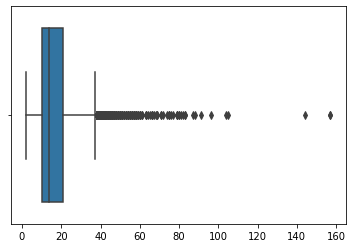

In [27]:
sns.boxplot(lengths)
plt.show()

In [112]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 40  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [113]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 2698 4986    6 1359   20   11  204   15   11 4196    1] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1
 1 1 1]


In [114]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [115]:
len(Y[0])

40

In [116]:
#! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [117]:
#! gunzip  GoogleNews-vectors-negative300.bin.gz 


In [32]:
# word2vec

path = './GoogleNews-vectors-negative300.bin'


# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
# word2vec effectiveness
#word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

In [118]:
# assign word vectors from word2vec model
import numpy as np
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [119]:

print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (30059, 300)


In [120]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

In [121]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [122]:
print(Y.shape)

(25825, 40, 4)


In [123]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [124]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [125]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (18658, 40)
Shape of output sequences: (18658, 40, 4)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (3293, 40)
Shape of output sequences: (3293, 40, 4)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (3874, 40)
Shape of output sequences: (3874, 40, 4)


In [126]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [127]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))


In [128]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 300)           9017700   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40, 64)            23360     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 4)             260       
Total params: 9,041,320
Trainable params: 23,620
Non-trainable params: 9,017,700
_________________________________________________________________


In [129]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [130]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 300)           9017700   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40, 64)            23360     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 4)             260       
Total params: 9,041,320
Trainable params: 23,620
Non-trainable params: 9,017,700
_________________________________________________________________


In [131]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
146/146 [==============================] - 5s 25ms/step - loss: 0.3540 - acc: 0.9327 - val_loss: 0.0647 - val_acc: 0.9860
Epoch 2/10
146/146 [==============================] - 3s 24ms/step - loss: 0.0575 - acc: 0.9903 - val_loss: 0.0454 - val_acc: 0.9930
Epoch 3/10
146/146 [==============================] - 3s 23ms/step - loss: 0.0437 - acc: 0.9931 - val_loss: 0.0404 - val_acc: 0.9933
Epoch 4/10
146/146 [==============================] - 3s 23ms/step - loss: 0.0401 - acc: 0.9932 - val_loss: 0.0382 - val_acc: 0.9933
Epoch 5/10
146/146 [==============================] - 4s 24ms/step - loss: 0.0388 - acc: 0.9931 - val_loss: 0.0371 - val_acc: 0.9934
Epoch 6/10
146/146 [==============================] - 3s 24ms/step - loss: 0.0381 - acc: 0.9931 - val_loss: 0.0362 - val_acc: 0.9934
Epoch 7/10
146/146 [==============================] - 3s 24ms/step - loss: 0.0364 - acc: 0.9933 - val_loss: 0.0351 - val_acc: 0.9935
Epoch 8/10
146/146 [==============================] - 3s 24ms/step - 

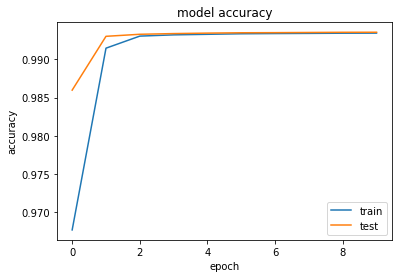

In [132]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [133]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [134]:
bidirect_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 300)           9017700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 128)           186880    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 4)             516       
Total params: 9,205,096
Trainable params: 9,205,096
Non-trainable params: 0
_________________________________________________________________


In [135]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [136]:
# check summary of model
bidirect_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 300)           9017700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 128)           186880    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 4)             516       
Total params: 9,205,096
Trainable params: 9,205,096
Non-trainable params: 0
_________________________________________________________________


In [137]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
146/146 [==============================] - 28s 163ms/step - loss: 0.3917 - acc: 0.9422 - val_loss: 0.0369 - val_acc: 0.9929
Epoch 2/10
146/146 [==============================] - 22s 154ms/step - loss: 0.0329 - acc: 0.9933 - val_loss: 0.0276 - val_acc: 0.9933
Epoch 3/10
146/146 [==============================] - 22s 152ms/step - loss: 0.0237 - acc: 0.9937 - val_loss: 0.0260 - val_acc: 0.9931
Epoch 4/10
146/146 [==============================] - 22s 150ms/step - loss: 0.0212 - acc: 0.9936 - val_loss: 0.0251 - val_acc: 0.9932
Epoch 5/10
146/146 [==============================] - 22s 148ms/step - loss: 0.0190 - acc: 0.9939 - val_loss: 0.0247 - val_acc: 0.9933
Epoch 6/10
146/146 [==============================] - 21s 146ms/step - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0259 - val_acc: 0.9929
Epoch 7/10
146/146 [==============================] - 21s 146ms/step - loss: 0.0114 - acc: 0.9962 - val_loss: 0.0284 - val_acc: 0.9926
Epoch 8/10
146/146 [==============================] - 2

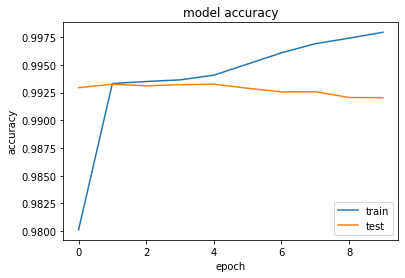

In [138]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()


## Test Metrics

In [140]:
X_val = [] # store input sequence
Y_val = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X_val.append(X_sentence)
    Y_val.append(Y_sentence)

In [141]:
X_val_encoded = word_tokenizer.texts_to_sequences(X_val) 
Y_val_encoded = tag_tokenizer.texts_to_sequences(Y_val)

In [142]:
MAX_SEQ_LENGTH = 40 # sequences greater than 100 in length will be truncated

X_val_padded = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_val_padded = pad_sequences(Y_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [153]:
X_val, Y_val = X_val_padded, Y_val_padded

In [154]:
Y_val = to_categorical(Y_val)

In [155]:
Y_val_predict=bidirect_model.predict_classes(X_val)

In [152]:
Y_val

array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1.

In [150]:
Y_val_predict

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [75]:
from sklearn.metrics import confusion_matrix

In [105]:
confusion_matrix(Y_val, Y_val_predict)

ValueError: Classification metrics can't handle a mix of unknown and multiclass-multioutput targets

In [100]:
Y_val_predict

array([[[9.99912381e-01, 2.29110065e-05, 5.91074831e-06, 5.87239847e-05],
        [9.99975681e-01, 4.18646005e-06, 2.04926846e-06, 1.81028918e-05],
        [9.99993205e-01, 7.55036638e-07, 6.99561156e-07, 5.33346110e-06],
        ...,
        [1.88970444e-06, 9.99821126e-01, 3.49944785e-05, 1.41961951e-04],
        [3.97596932e-06, 9.98619676e-01, 7.04175560e-04, 6.72290858e-04],
        [4.75862180e-06, 9.99780476e-01, 5.24999450e-05, 1.62306518e-04]],

       [[9.99912381e-01, 2.29108755e-05, 5.91080470e-06, 5.87244358e-05],
        [9.99975681e-01, 4.18643594e-06, 2.04929188e-06, 1.81030646e-05],
        [9.99993205e-01, 7.55030896e-07, 6.99569171e-07, 5.33350703e-06],
        ...,
        [3.52561187e-07, 9.99882817e-01, 3.79329213e-05, 7.88882535e-05],
        [1.12420421e-04, 8.66280556e-01, 1.26135513e-01, 7.47153396e-03],
        [1.13861495e-06, 9.99923348e-01, 1.42320032e-05, 6.12876902e-05]],

       [[9.99912381e-01, 2.29168636e-05, 5.90855007e-06, 5.87065151e-05],
        

In [102]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)

122/122 [==============================] - 4s 31ms/step - loss: 0.0130 - acc: 0.9968


In [103]:
bidirect_model.predict_classes(X_test)

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [96]:
zz = np.argmax(Y_val_predict,2)

In [98]:
zz

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [99]:
Y_val

array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1.